In [1]:
import pandas as pd
import os
from project.dataset import Dataset, VALDODataset
from project.preprocessing import z_score_normalization, min_max_normalization, NiftiToTensorTransform
from project.training import split_train_val_datasets
from project.utils import collate_fn, plot_all_slices, plot_all_slices_from_array
from torch.utils.data import DataLoader
import torch
from project.model import VisionTransformer
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
d_model = 3
n_classes = 2
img_size = (512,512)
patch_size = (16,16)
n_channels = 1
n_heads = 3
n_layers = 3
batch_size = 1
epochs = 3
alpha = 0.004

In [3]:
ds = Dataset()

In [4]:
masks = ds.load_cmb_masks(cohort_num=1)
cases = ds.load_skullstripped_mri(cohort_num=1)
# cases = ds.load_raw_mri(cohort_num=1)

In [5]:
transform = NiftiToTensorTransform(target_shape=img_size)

In [6]:
dataset = VALDODataset(
    cases=cases, 
    masks=masks, 
    transform=transform,
    normalization=z_score_normalization
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [7]:
print(type(dataset))
print(len(dataset))

<class 'project.dataset.valdo.VALDODataset'>
11


In [8]:
has_cmb = [1 if count > 0 else 0 for count in dataset.cmb_counts]

df_dataset = pd.DataFrame({
    'MRI Scans': dataset.cases,
    'Segmented Masks': dataset.masks,
    'CMB Count': dataset.cmb_counts,
    'Has CMB': has_cmb
})

In [9]:
train_dataset, val_dataset = split_train_val_datasets(
    df=df_dataset, 
    transform=transform
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [10]:
train_loader = DataLoader(
    train_dataset, 
    shuffle=True, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    val_dataset, 
    shuffle=False, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
transformer = VisionTransformer(
    d_model=d_model,
    n_classes=n_classes,
    img_size=img_size,
    patch_size=patch_size,
    n_channels=n_channels,
    n_heads=n_heads,
    n_layers=n_layers,
    device=device
)

In [13]:
transformer = transformer.to(device)

In [14]:
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

d:\Programming Files\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
from tqdm.auto import tqdm

for epoch in range(epochs):
    training_loss = 0.0
    progress_bar = tqdm(
        enumerate(train_loader, 0),
        total=len(train_loader),
        desc=f'Epoch {epoch + 1}/{epochs} loss: {training_loss / len(train_loader):.3f}'
    )
    
    for i, data in progress_bar:
        num_slices = len(data[0])
        
        for j in range(num_slices):
            inputs = data[0][j].float().to(device)
            labels = data[1][j].float().to(device)
            
            print('-----------------------')
            print(f'Learning case {i} slice {j}')
            
            optimizer.zero_grad()
            outputs, loss = transformer(inputs, labels)
            outputs = F.interpolate(
                outputs,
                size=img_size,
                mode='bilinear',
                align_corners=False
            )
            
            if labels.max() >= n_classes:
                labels = torch.clamp(labels, 0, n_classes-1)
                
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
        
    print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss:.3f}')

Epoch 1/3 loss: 0.000:   0%|          | 0/8 [00:00<?, ?it/s]

-----------------------
Learning case 0 slice 0
Loss:  tensor(2.2520, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 1
Loss:  tensor(2.2449, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 2
Loss:  tensor(2.2377, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 3
Loss:  tensor(2.2306, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 4
Loss:  tensor(2.2235, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 5
Loss:  tensor(2.2162, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 6
Loss:  tensor(2.2092, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 7
Loss:  tensor(2.2021, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 8
Loss:  tensor(2.

Epoch 1/3 loss: 0.000:  12%|█▎        | 1/8 [00:01<00:10,  1.57s/it]

-----------------------
Learning case 1 slice 0
Loss:  tensor(2.0062, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 1
Loss:  tensor(1.9994, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 2
Loss:  tensor(1.9925, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 3
Loss:  tensor(1.9857, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 4
Loss:  tensor(1.9788, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 5
Loss:  tensor(1.9720, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 6
Loss:  tensor(1.9652, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 7
Loss:  tensor(1.9584, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 8
Loss:  tensor(1.

Epoch 1/3 loss: 0.000:  25%|██▌       | 2/8 [00:02<00:08,  1.36s/it]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


-----------------------
Learning case 1 slice 32
Loss:  tensor(1.7923, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 33
Loss:  tensor(1.7858, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 34
Loss:  tensor(1.7794, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 0
Loss:  tensor(1.7729, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 1
Loss:  tensor(1.7665, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 2
Loss:  tensor(1.7600, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 3
Loss:  tensor(1.7536, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 4
Loss:  tensor(1.7472, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 5
Loss:  tensor

Epoch 1/3 loss: 0.000:  38%|███▊      | 3/8 [00:04<00:06,  1.31s/it]

-----------------------
Learning case 2 slice 32
Loss:  tensor(1.5733, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 33
Loss:  tensor(1.5673, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 34
Loss:  tensor(1.5613, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 0
Loss:  tensor(1.5553, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 1
Loss:  tensor(1.5493, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 2
Loss:  tensor(1.5434, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 3
Loss:  tensor(1.5375, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 4
Loss:  tensor(1.5315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 5
Loss:  tensor

Epoch 1/3 loss: 0.000:  50%|█████     | 4/8 [00:05<00:05,  1.28s/it]

Loss:  tensor(1.3830, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 31
Loss:  tensor(1.3775, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 32
Loss:  tensor(1.3720, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 33
Loss:  tensor(1.3666, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 34
Loss:  tensor(1.3611, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 0
Loss:  tensor(1.3557, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 1
Loss:  tensor(1.3503, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 2
Loss:  tensor(1.3449, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 3
Loss:  tensor(1.3395, device='cuda:0', grad_fn=<NllLoss2DBac

Epoch 1/3 loss: 0.000:  62%|██████▎   | 5/8 [00:06<00:03,  1.30s/it]

-----------------------
Learning case 5 slice 0
Loss:  tensor(1.1757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 1
Loss:  tensor(1.1708, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 2
Loss:  tensor(1.1660, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 3
Loss:  tensor(1.1612, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 4
Loss:  tensor(1.1564, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 5
Loss:  tensor(1.1516, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 6
Loss:  tensor(1.1468, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 7
Loss:  tensor(1.1421, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 8
Loss:  tensor(1.

Epoch 1/3 loss: 0.000:  75%|███████▌  | 6/8 [00:07<00:02,  1.30s/it]

-----------------------
Learning case 6 slice 0
Loss:  tensor(1.0161, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 1
Loss:  tensor(1.0118, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 2
Loss:  tensor(1.0076, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 3
Loss:  tensor(1.0033, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 4
Loss:  tensor(0.9991, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 5
Loss:  tensor(0.9949, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 6
Loss:  tensor(0.9908, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 7
Loss:  tensor(0.9866, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 8
Loss:  tensor(0.

Epoch 1/3 loss: 0.000:  88%|████████▊ | 7/8 [00:09<00:01,  1.30s/it]

Loss:  tensor(0.8992, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 30
Loss:  tensor(0.8955, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 31
Loss:  tensor(0.8917, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 32
Loss:  tensor(0.8879, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 33
Loss:  tensor(0.8842, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 34
Loss:  tensor(0.8805, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 0
Loss:  tensor(0.8768, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 1
Loss:  tensor(0.8731, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 2
Loss:  tensor(0.8694, device='cuda:0', grad_fn=<NllLoss2DBa

Epoch 1/3 loss: 0.000: 100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


-----------------------
Learning case 7 slice 29
Loss:  tensor(0.7761, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 30
Loss:  tensor(0.7728, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 31
Loss:  tensor(0.7696, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 32
Loss:  tensor(0.7664, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 33
Loss:  tensor(0.7632, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 34
Loss:  tensor(0.7600, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Epoch 1/3 loss: 394.543


Epoch 2/3 loss: 0.000:   0%|          | 0/8 [00:00<?, ?it/s]

-----------------------
Learning case 0 slice 0
Loss:  tensor(0.7568, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 1
Loss:  tensor(0.7537, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 2
Loss:  tensor(0.7505, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 3
Loss:  tensor(0.7474, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 4
Loss:  tensor(0.7443, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 5
Loss:  tensor(0.7412, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 6
Loss:  tensor(0.7381, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 7
Loss:  tensor(0.7350, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 8
Loss:  tensor(0.

Epoch 2/3 loss: 0.000:  12%|█▎        | 1/8 [00:01<00:09,  1.32s/it]

-----------------------
Learning case 1 slice 0
Loss:  tensor(0.6547, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 1
Loss:  tensor(0.6520, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 2
Loss:  tensor(0.6493, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 3
Loss:  tensor(0.6467, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 4
Loss:  tensor(0.6440, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 5
Loss:  tensor(0.6414, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 6
Loss:  tensor(0.6388, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 7
Loss:  tensor(0.6362, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 8
Loss:  tensor(0.

Epoch 2/3 loss: 0.000:  25%|██▌       | 2/8 [00:02<00:07,  1.30s/it]

-----------------------
Learning case 1 slice 30
Loss:  tensor(0.5797, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 31
Loss:  tensor(0.5773, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 32
Loss:  tensor(0.5750, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 33
Loss:  tensor(0.5727, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 34
Loss:  tensor(0.5705, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 0
Loss:  tensor(0.5682, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 1
Loss:  tensor(0.5659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 2
Loss:  tensor(0.5637, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 3
Loss:  tens

Epoch 2/3 loss: 0.000:  38%|███▊      | 3/8 [00:03<00:06,  1.29s/it]

Loss:  tensor(0.5069, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 30
Loss:  tensor(0.5050, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 31
Loss:  tensor(0.5030, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 32
Loss:  tensor(0.5011, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 33
Loss:  tensor(0.4992, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 34
Loss:  tensor(0.4972, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 0
Loss:  tensor(0.4953, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 1
Loss:  tensor(0.4934, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 2
Loss:  tensor(0.4915, device='cuda:0', grad_fn=<NllLoss2DBa

Epoch 2/3 loss: 0.000:  50%|█████     | 4/8 [00:05<00:05,  1.29s/it]

Loss:  tensor(0.4438, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 30
Loss:  tensor(0.4422, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 31
Loss:  tensor(0.4405, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 32
Loss:  tensor(0.4389, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 33
Loss:  tensor(0.4373, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 34
Loss:  tensor(0.4356, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 0
Loss:  tensor(0.4340, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 1
Loss:  tensor(0.4324, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 2
Loss:  tensor(0.4308, device='cuda:0', grad_fn=<NllLoss2DBa

Epoch 2/3 loss: 0.000:  62%|██████▎   | 5/8 [00:06<00:03,  1.30s/it]

-----------------------
Learning case 4 slice 29
Loss:  tensor(0.3906, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 30
Loss:  tensor(0.3892, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 31
Loss:  tensor(0.3879, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 32
Loss:  tensor(0.3865, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 33
Loss:  tensor(0.3851, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 34
Loss:  tensor(0.3837, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


-----------------------
Learning case 5 slice 0
Loss:  tensor(0.3824, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 1
Loss:  tensor(0.3810, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 2
Loss:  tensor(0.3797, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 3
Loss:  tensor(0.3784, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 4
Loss:  tensor(0.3770, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 5
Loss:  tensor(0.3757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 6
Loss:  tensor(0.3744, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 7
Loss:  tensor(0.3731, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 8
Loss:  tensor(0.

Epoch 2/3 loss: 0.000:  75%|███████▌  | 6/8 [00:07<00:02,  1.31s/it]

Loss:  tensor(0.3457, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 30
Loss:  tensor(0.3446, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 31
Loss:  tensor(0.3434, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 32
Loss:  tensor(0.3422, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 33
Loss:  tensor(0.3411, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 34
Loss:  tensor(0.3399, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 0
Loss:  tensor(0.3388, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 1
Loss:  tensor(0.3376, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 2
Loss:  tensor(0.3365, device='cuda:0', grad_fn=<NllLoss2DBa

Epoch 2/3 loss: 0.000:  88%|████████▊ | 7/8 [00:09<00:01,  1.32s/it]

-----------------------
Learning case 6 slice 29
Loss:  tensor(0.3077, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 30
Loss:  tensor(0.3067, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 31
Loss:  tensor(0.3057, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 32
Loss:  tensor(0.3047, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 33
Loss:  tensor(0.3037, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 34
Loss:  tensor(0.3028, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 0
Loss:  tensor(0.3018, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 1
Loss:  tensor(0.3008, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 2
Loss:  ten

Epoch 2/3 loss: 0.000: 100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


-----------------------
Learning case 7 slice 30
Loss:  tensor(0.2745, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 31
Loss:  tensor(0.2736, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 32
Loss:  tensor(0.2728, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 33
Loss:  tensor(0.2719, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 34
Loss:  tensor(0.2711, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Epoch 2/3 loss: 129.113


Epoch 3/3 loss: 0.000:   0%|          | 0/8 [00:00<?, ?it/s]

-----------------------
Learning case 0 slice 0
Loss:  tensor(0.2703, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 1
Loss:  tensor(0.2694, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 2
Loss:  tensor(0.2686, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 3
Loss:  tensor(0.2678, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 4
Loss:  tensor(0.2670, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 5
Loss:  tensor(0.2662, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 6
Loss:  tensor(0.2654, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 7
Loss:  tensor(0.2645, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 0 slice 8
Loss:  tensor(0.

Epoch 3/3 loss: 0.000:  12%|█▎        | 1/8 [00:01<00:09,  1.34s/it]

-----------------------
Learning case 1 slice 0
Loss:  tensor(0.2433, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 1
Loss:  tensor(0.2426, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 2
Loss:  tensor(0.2419, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 3
Loss:  tensor(0.2412, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 4
Loss:  tensor(0.2405, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 5
Loss:  tensor(0.2398, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 6
Loss:  tensor(0.2391, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 7
Loss:  tensor(0.2384, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 8
Loss:  tensor(0.

Epoch 3/3 loss: 0.000:  25%|██▌       | 2/8 [00:02<00:07,  1.32s/it]

Loss:  tensor(0.2238, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 30
Loss:  tensor(0.2232, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 31
Loss:  tensor(0.2226, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 32
Loss:  tensor(0.2219, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 33
Loss:  tensor(0.2213, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 1 slice 34
Loss:  tensor(0.2207, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 0
Loss:  tensor(0.2201, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 1
Loss:  tensor(0.2195, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 2
Loss:  tensor(0.2188, device='cuda:0', grad_fn=<NllLoss2DBa

Epoch 3/3 loss: 0.000:  38%|███▊      | 3/8 [00:03<00:06,  1.31s/it]

-----------------------
Learning case 2 slice 30
Loss:  tensor(0.2027, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 31
Loss:  tensor(0.2021, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 32
Loss:  tensor(0.2016, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 33
Loss:  tensor(0.2010, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 2 slice 34
Loss:  tensor(0.2005, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 0
Loss:  tensor(0.2000, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 1
Loss:  tensor(0.1994, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 2
Loss:  tensor(0.1989, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 3 slice 3
Loss:  tens

Epoch 3/3 loss: 0.000:  50%|█████     | 4/8 [00:05<00:05,  1.31s/it]

-----------------------
Learning case 4 slice 0
Loss:  tensor(0.1825, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 1
Loss:  tensor(0.1820, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 2
Loss:  tensor(0.1815, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 3
Loss:  tensor(0.1811, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 4
Loss:  tensor(0.1806, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 5
Loss:  tensor(0.1801, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 6
Loss:  tensor(0.1797, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 7
Loss:  tensor(0.1792, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 8
Loss:  tensor(0.

Epoch 3/3 loss: 0.000:  62%|██████▎   | 5/8 [00:06<00:03,  1.29s/it]

-----------------------
Learning case 4 slice 31
Loss:  tensor(0.1688, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 32
Loss:  tensor(0.1684, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 33
Loss:  tensor(0.1680, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 4 slice 34
Loss:  tensor(0.1676, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 0
Loss:  tensor(0.1671, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 1
Loss:  tensor(0.1667, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 2
Loss:  tensor(0.1663, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 3
Loss:  tensor(0.1659, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 4
Loss:  tenso

Epoch 3/3 loss: 0.000:  75%|███████▌  | 6/8 [00:07<00:02,  1.29s/it]

-----------------------
Learning case 5 slice 31
Loss:  tensor(0.1551, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 32
Loss:  tensor(0.1548, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 33
Loss:  tensor(0.1544, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 5 slice 34
Loss:  tensor(0.1540, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


-----------------------
Learning case 6 slice 0
Loss:  tensor(0.1537, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 1
Loss:  tensor(0.1533, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 2
Loss:  tensor(0.1530, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 3
Loss:  tensor(0.1526, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 4
Loss:  tensor(0.1522, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 5
Loss:  tensor(0.1519, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 6
Loss:  tensor(0.1515, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 7
Loss:  tensor(0.1512, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 8
Loss:  tensor(0.

Epoch 3/3 loss: 0.000:  88%|████████▊ | 7/8 [00:09<00:01,  1.29s/it]

Loss:  tensor(0.1434, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 31
Loss:  tensor(0.1431, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 32
Loss:  tensor(0.1427, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 33
Loss:  tensor(0.1424, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 6 slice 34
Loss:  tensor(0.1421, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 0
Loss:  tensor(0.1418, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 1
Loss:  tensor(0.1415, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 2
Loss:  tensor(0.1411, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 3
Loss:  tensor(0.1408, device='cuda:0', grad_fn=<NllLoss2DBac

Epoch 3/3 loss: 0.000: 100%|██████████| 8/8 [00:10<00:00,  1.30s/it]

-----------------------
Learning case 7 slice 30
Loss:  tensor(0.1326, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 31
Loss:  tensor(0.1323, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 32
Loss:  tensor(0.1321, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 33
Loss:  tensor(0.1318, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
-----------------------
Learning case 7 slice 34
Loss:  tensor(0.1315, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Epoch 3/3 loss: 52.842


In [16]:
dir_path = 'experiments'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
file_num = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
torch.save(transformer.state_dict(), f'experiments/ViT{file_num + 1}.pth')

In [17]:
transformer.to(device)
transformer.load_state_dict(torch.load(f"Experiments/ViT{file_num+1}.pth"))
transformer.eval()

VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (linear_project): Conv2d(1, 3, kernel_size=(16, 16), stride=(16, 16))
  )
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): Sequential(
    (0): TransformerEncoder(
      (ln1): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (W_o): Linear(in_features=3, out_features=3, bias=True)
        (heads): ModuleList(
          (0-2): 3 x AttentionHead(
            (query): Linear(in_features=3, out_features=1, bias=True)
            (key): Linear(in_features=3, out_features=1, bias=True)
            (value): Linear(in_features=3, out_features=1, bias=True)
          )
        )
      )
      (ln2): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=3, out_features=12, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=12, out_features=3, bias=True)
      )
    )
    (1): TransformerE

In [20]:
def predict(model, image):
    model.eval()
    
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        output = F.interpolate(output, size=img_size, mode='bilinear', align_corners=False)
        prediction = torch.argmax(output, dim=1)
        
    return prediction.cpu().numpy()

In [21]:
val_loss = 0.0
predicted = []

length = len(test_loader)
case = 0 
with torch.no_grad():
    for i, val_batch in tqdm(enumerate(test_loader, 0)):
        num_slices = len(val_batch[0])
        val_slices = []
        one_case = []
        val_masks = []
        
        for j in range(num_slices):
            print(f'Predicting case {i} slice {j}')
            val_images = val_batch[0][j].float().to(device)
            val_mask = val_batch[1][j].float().to(device) 
            
            predicted_mask = predict(transformer, val_images)
 
            predicted_mask = torch.from_numpy(predicted_mask).unsqueeze(1).to(device).float()
            predicted_mask = F.interpolate(
                predicted_mask, 
                size=img_size, 
                mode='nearest'
            ).squeeze(1)

            val_loss += criterion(predicted_mask, val_mask).item() 
            val_slices.append(predicted_mask)
            val_masks.append(val_mask)
            
            print('Loss:', val_loss)
        one_case.append(val_slices)
        one_case.append(val_masks)
        predicted.append(one_case)
        case += 1

print(f' Final Validation Loss: {val_loss}')

0it [00:00, ?it/s]

Predicting case 0 slice 0
Loss: 0.0
Predicting case 0 slice 1
Loss: 0.0
Predicting case 0 slice 2
Loss: 0.0
Predicting case 0 slice 3
Loss: 0.0
Predicting case 0 slice 4
Loss: 0.0
Predicting case 0 slice 5
Loss: 0.0
Predicting case 0 slice 6
Loss: 0.0
Predicting case 0 slice 7
Loss: 0.0
Predicting case 0 slice 8
Loss: 0.0
Predicting case 0 slice 9
Loss: 0.0
Predicting case 0 slice 10
Loss: 0.0
Predicting case 0 slice 11
Loss: 0.0
Predicting case 0 slice 12
Loss: 0.0
Predicting case 0 slice 13
Loss: 0.0
Predicting case 0 slice 14
Loss: 0.0
Predicting case 0 slice 15
Loss: 0.0
Predicting case 0 slice 16
Loss: 0.0
Predicting case 0 slice 17
Loss: 0.0
Predicting case 0 slice 18
Loss: 0.0
Predicting case 0 slice 19
Loss: 0.0
Predicting case 0 slice 20
Loss: 0.0
Predicting case 0 slice 21
Loss: 0.0
Predicting case 0 slice 22
Loss: 0.0
Predicting case 0 slice 23
Loss: 0.0
Predicting case 0 slice 24
Loss: 0.0
Predicting case 0 slice 25
Loss: 0.0
Predicting case 0 slice 26
Loss: 0.0
Predicting 

1it [00:00,  1.35it/s]

Loss: 0.0
Predicting case 0 slice 32
Loss: 0.0
Predicting case 0 slice 33
Loss: 0.0
Predicting case 0 slice 34
Loss: 0.0
Predicting case 1 slice 0
Loss: 0.0
Predicting case 1 slice 1
Loss: 0.0
Predicting case 1 slice 2
Loss: 0.0
Predicting case 1 slice 3
Loss: 0.0
Predicting case 1 slice 4
Loss: 0.0
Predicting case 1 slice 5
Loss: 0.0
Predicting case 1 slice 6
Loss: 0.0
Predicting case 1 slice 7
Loss: 0.0
Predicting case 1 slice 8
Loss: 0.0
Predicting case 1 slice 9
Loss: 0.0
Predicting case 1 slice 10
Loss: 0.0
Predicting case 1 slice 11
Loss: 0.45081645250320435
Predicting case 1 slice 12
Loss: 0.45081645250320435
Predicting case 1 slice 13
Loss: 0.45081645250320435
Predicting case 1 slice 14
Loss: 0.6335798799991608
Predicting case 1 slice 15
Loss: 0.6335798799991608
Predicting case 1 slice 16
Loss: 0.6335798799991608
Predicting case 1 slice 17
Loss: 0.6335798799991608
Predicting case 1 slice 18


2it [00:01,  1.43it/s]

Loss: 0.779790610074997
Predicting case 1 slice 19
Loss: 1.2306070625782013
Predicting case 1 slice 20
Loss: 1.5961338877677917
Predicting case 1 slice 21
Loss: 2.7292670607566833
Predicting case 1 slice 22
Loss: 4.642190754413605
Predicting case 1 slice 23
Loss: 6.396719515323639
Predicting case 1 slice 24
Loss: 8.991960108280182
Predicting case 1 slice 25
Loss: 13.317360937595367
Predicting case 1 slice 26
Loss: 15.339942753314972
Predicting case 1 slice 27
Loss: 16.87515550851822
Predicting case 1 slice 28
Loss: 17.752419888973236
Predicting case 1 slice 29
Loss: 19.09268492460251
Predicting case 1 slice 30
Loss: 20.006501972675323
Predicting case 1 slice 31
Loss: 20.652266085147858
Predicting case 1 slice 32
Loss: 20.993424475193024
Predicting case 1 slice 33
Loss: 20.993424475193024
Predicting case 1 slice 34
Loss: 20.993424475193024
Predicting case 2 slice 0
Loss: 20.993424475193024
Predicting case 2 slice 1
Loss: 20.993424475193024
Predicting case 2 slice 2
Loss: 20.993424475193

3it [00:02,  1.47it/s]

Loss: 21.115266747772694
Predicting case 2 slice 20
Loss: 21.115266747772694
Predicting case 2 slice 21
Loss: 21.115266747772694
Predicting case 2 slice 22
Loss: 21.115266747772694
Predicting case 2 slice 23
Loss: 21.395504005253315
Predicting case 2 slice 24
Loss: 21.395504005253315
Predicting case 2 slice 25
Loss: 21.395504005253315
Predicting case 2 slice 26
Loss: 21.395504005253315
Predicting case 2 slice 27
Loss: 21.395504005253315
Predicting case 2 slice 28
Loss: 21.395504005253315
Predicting case 2 slice 29
Loss: 21.395504005253315
Predicting case 2 slice 30
Loss: 21.395504005253315
Predicting case 2 slice 31
Loss: 21.395504005253315
Predicting case 2 slice 32
Loss: 21.395504005253315
Predicting case 2 slice 33
Loss: 21.395504005253315
Predicting case 2 slice 34
Loss: 21.395504005253315
 Final Validation Loss: 21.395504005253315


Case 1: Number of slices: 35
Slice 0 unique values: 0.0
Slice 1 unique values: 0.0
Slice 2 unique values: 0.0
Slice 3 unique values: 0.0
Slice 4 unique values: 0.0
Slice 5 unique values: 0.0
Slice 6 unique values: 0.0
Slice 7 unique values: 0.0
Slice 8 unique values: 0.0
Slice 9 unique values: 0.0
Slice 10 unique values: 0.0
Slice 11 unique values: tensor([0., 1.], device='cuda:0')
Case 1 | Slice 11:  tensor([0., 1.], device='cuda:0')
Slice 12 unique values: 0.0
Slice 13 unique values: 0.0
Slice 14 unique values: tensor([0., 1.], device='cuda:0')
Case 1 | Slice 14:  tensor([0., 1.], device='cuda:0')
Slice 15 unique values: 0.0
Slice 16 unique values: 0.0
Slice 17 unique values: 0.0
Slice 18 unique values: tensor([0., 1.], device='cuda:0')
Case 1 | Slice 18:  tensor([0., 1.], device='cuda:0')
Slice 19 unique values: tensor([0., 1.], device='cuda:0')
Case 1 | Slice 19:  tensor([0., 1.], device='cuda:0')
Slice 20 unique values: tensor([0., 1.], device='cuda:0')
Case 1 | Slice 20:  tensor(

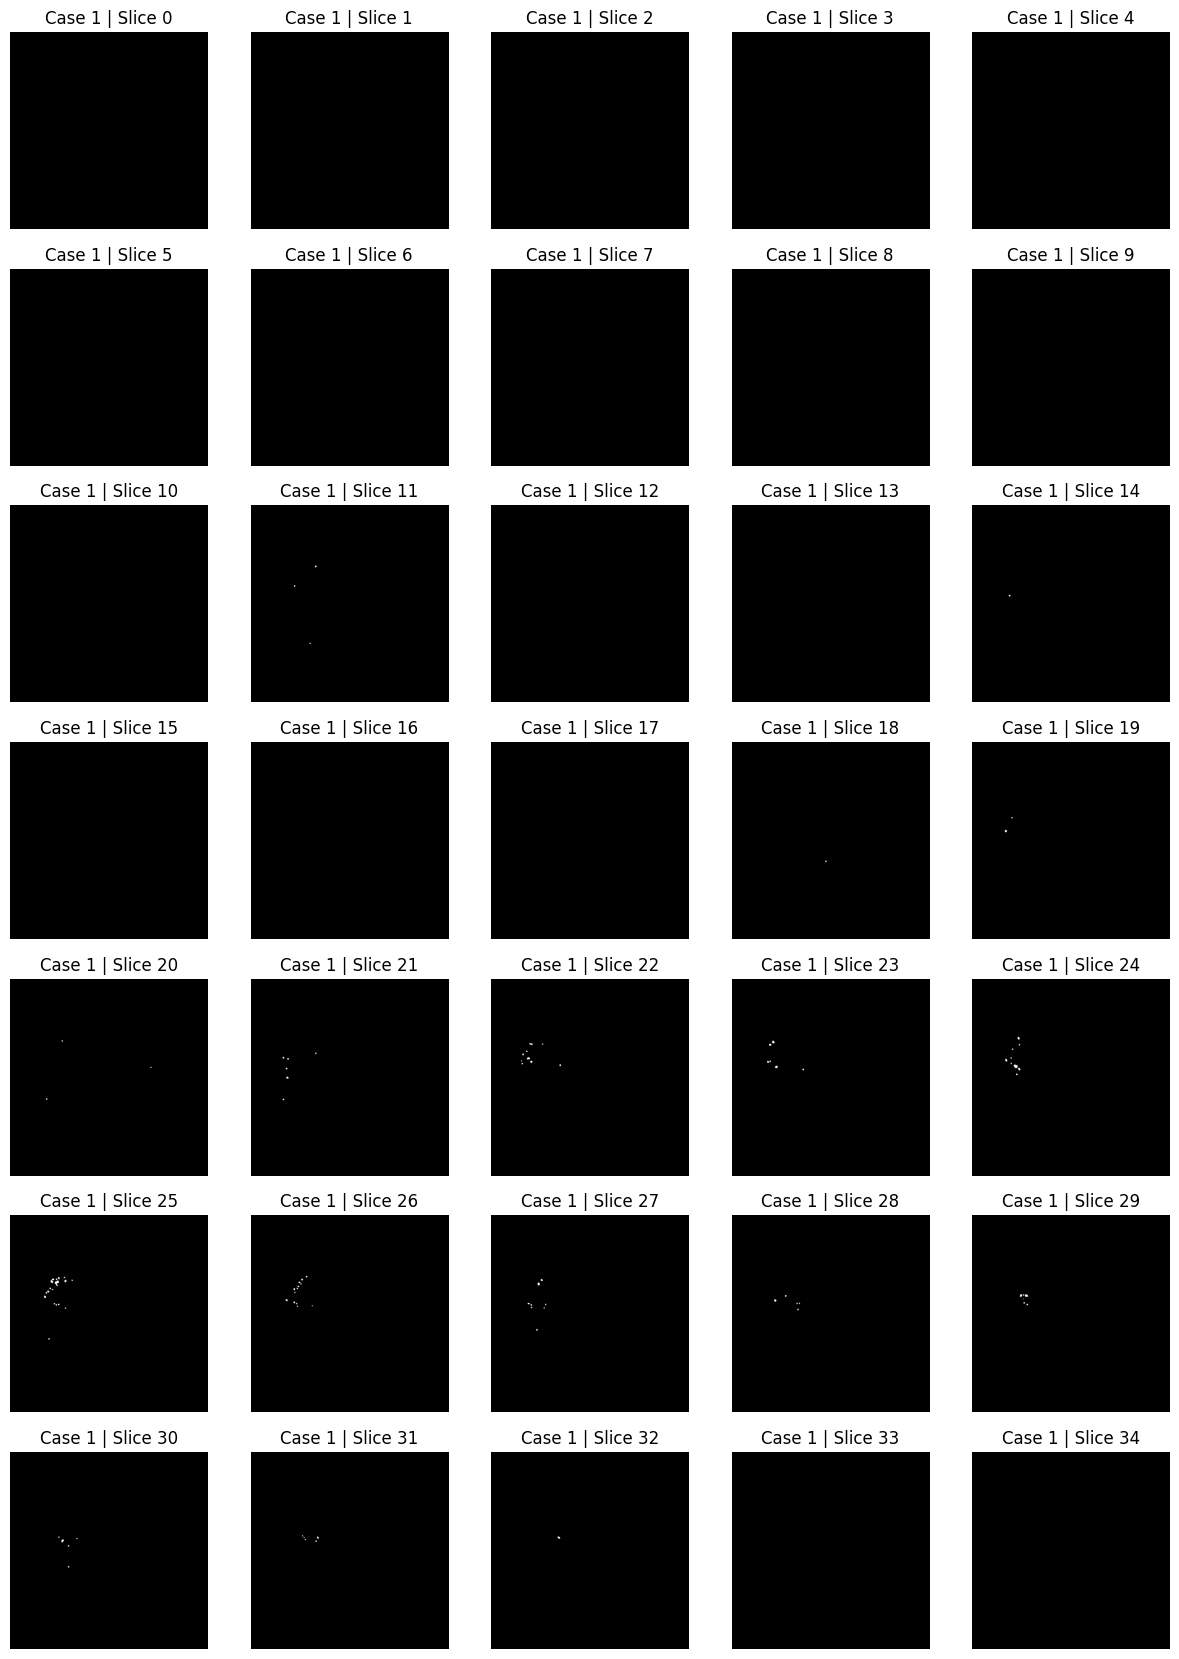

In [24]:
plot_all_slices_from_array(predicted, case_index=1)

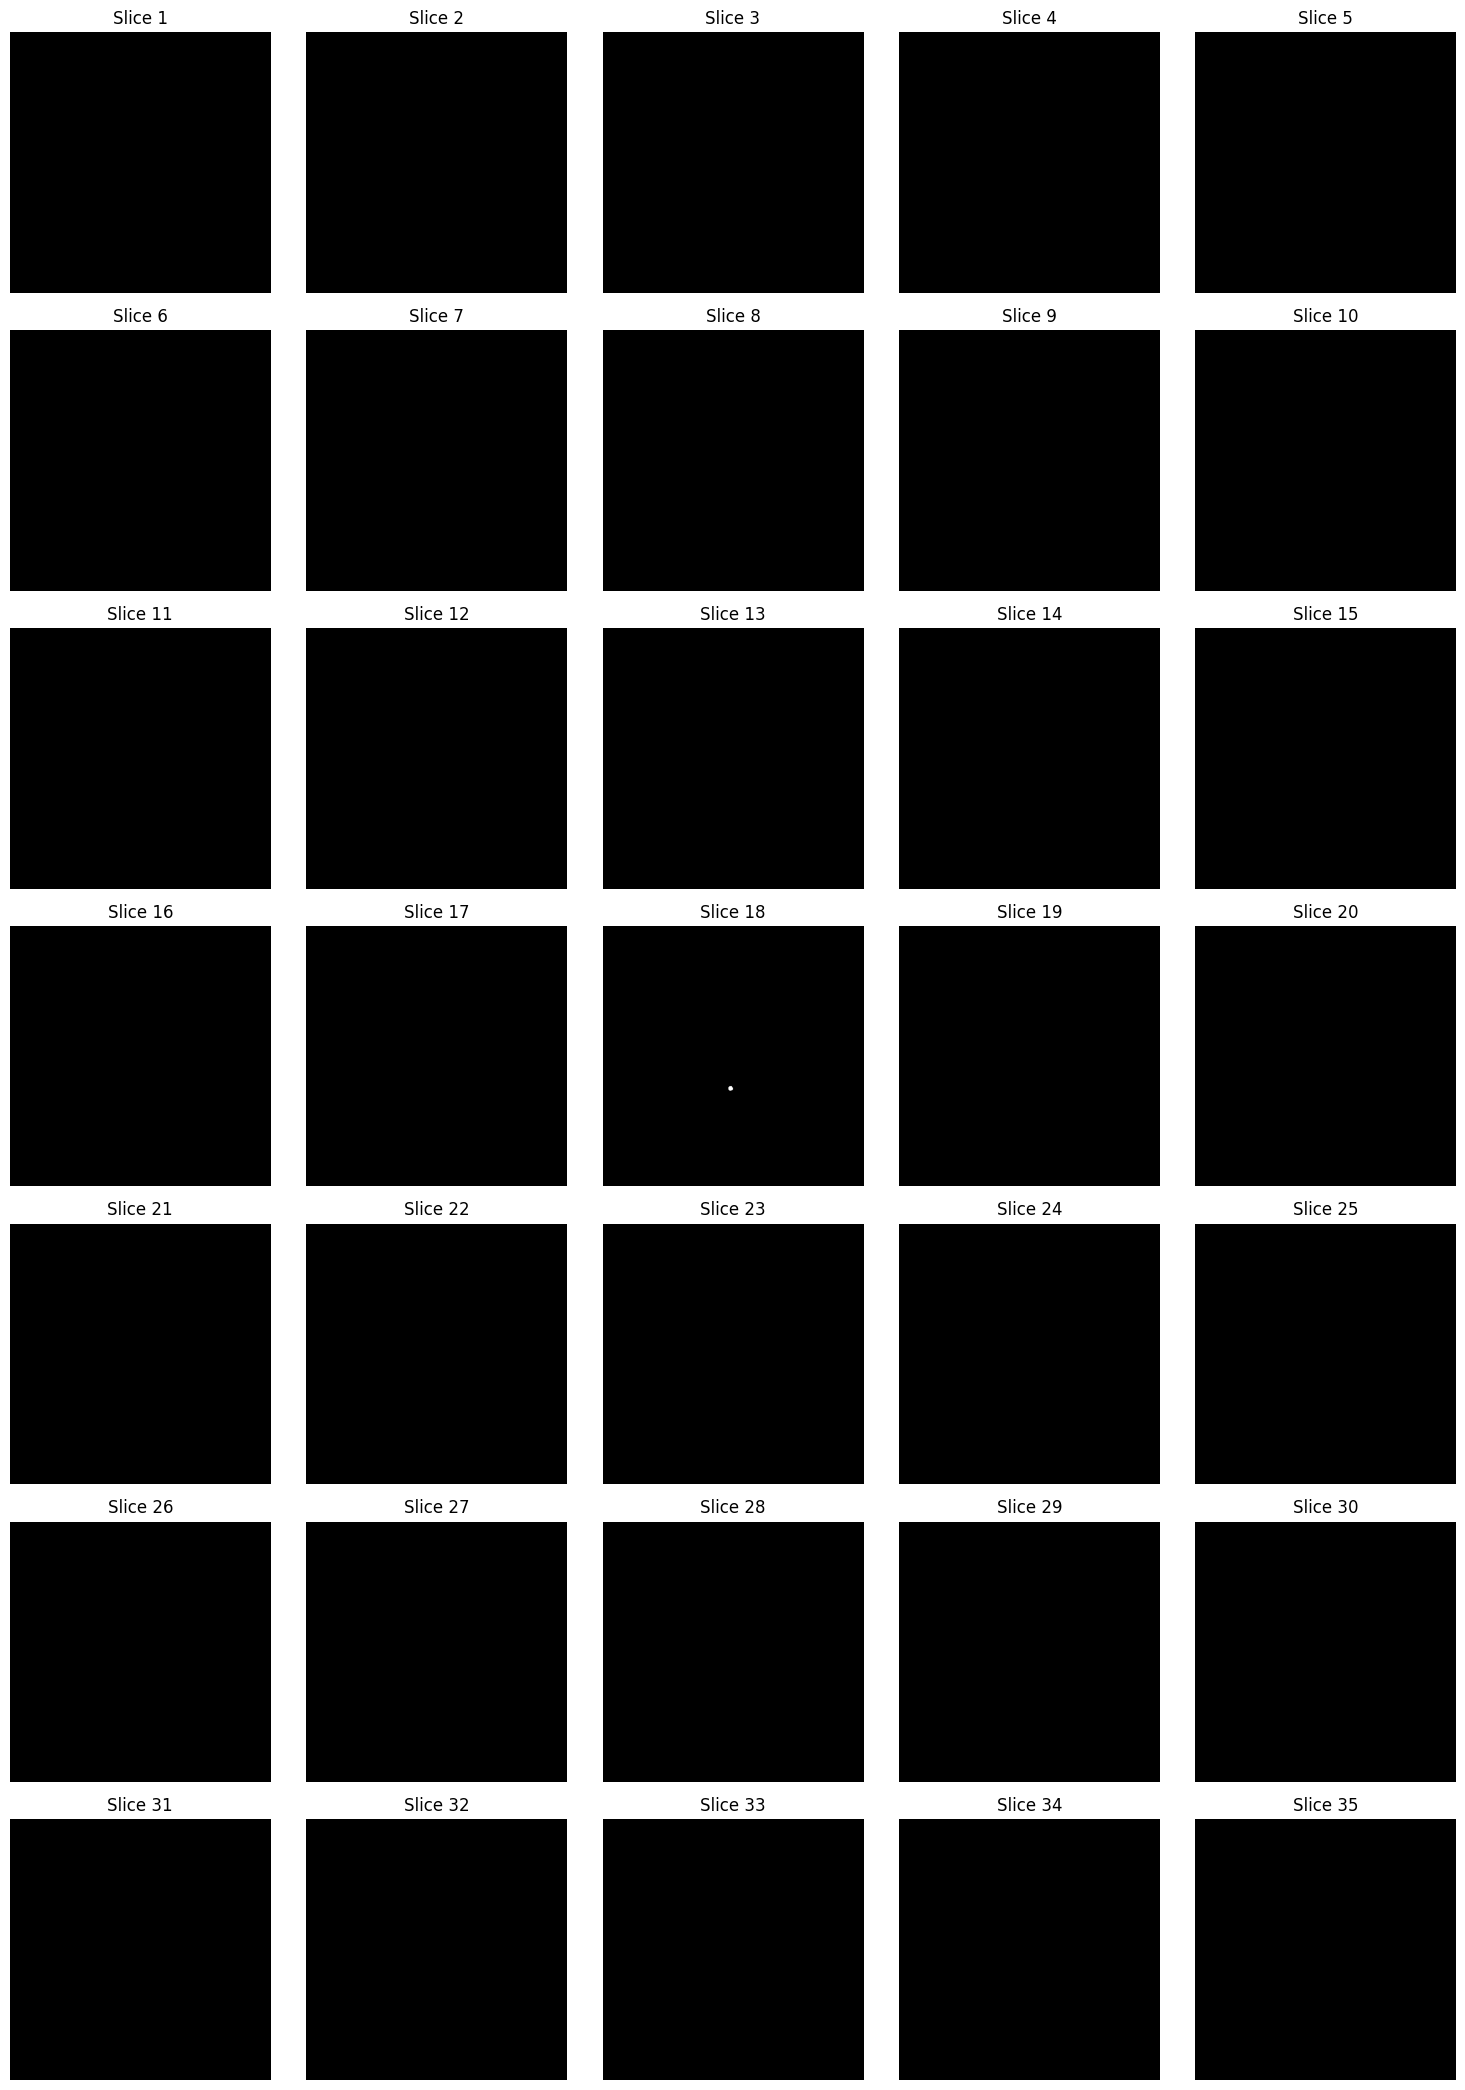

In [25]:
plot_all_slices(masks[1])